# Plots for cell segmentation

To see if the segmentation is acutally working we will generate a few plots for visualization. We will combine the TIF files and the cell polygons and the individual transcripts.

In [1]:
# import the libraries
import tifffile
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import geopandas as gpd
import geojson
import os
from shapely.geometry import shape
from shapely.ops import transform

## Define Path
I am running Baysor with different parameters, to see which one is the best fit, we will define a path here so that we can use the same script for all runs

In [2]:
path = "baysor_3_mol_per_cell/"

Similar to the `04_add_cell_to_transcripts` notebook, we will need to get the scaling factors to combine the TIF and the merscope coordinates.

In [3]:
def create_rescaling_function():
    """
    Here we create a rescaling function that takes three argument: x, y, z.
    These are the coordinates of out point. We will apply the transformation
    defined in 'micron_to_mosaic_pixel_transform' to convert the micron to pixel
    and then rescale it with the same scaling factor used in script '01'
    """
    # the get the size of the original image, we can take any of the images
    # they are all the same size
    size_original_image = tifffile.imread("../Merlin_output/images/mosaic_Cellbound2_z0.tif").shape
    
    # rescaled image
    size_rescaled_image = tifffile.imread("image/full_stack.tif").shape
    # since this is the stacked image, we dont need to keep all dimensions.
    size_rescaled_image = size_rescaled_image[2:4]
    
    scale_y = size_original_image[0] / size_rescaled_image[0]
    scale_x = size_original_image[1] / size_rescaled_image[1]
    rescale = np.array([scale_x, scale_y, 1])
    
    
    mmpt = pd.read_csv(
        "../Merlin_output/images/micron_to_mosaic_pixel_transform.csv", 
        header=None, 
        sep=' '
    )
    mmpt = np.array(mmpt)

    def rescale_fun(x,y,z):
        points = np.array([x,y,z])
        # coordinates to pixel
        points = np.diag(mmpt) * points.T + np.append(mmpt[0:2,2], 0)
        # apply our scaling
        points = points / rescale
        return(points.T)
    
    return(rescale_fun)

In [4]:
rescale_fun = create_rescaling_function()
rescale_fun

Shaped series: series shape does not match page shape


(3.0865665011414225, 3.0865709219772635)

Next, we import the TIFF file. We have 7 different z stacks, but we obivously cannot plot all of them. So for here, I am going to use the middle (z=3). Our tiff only contains two colors in the first dimension. To plot it, the colors need to be in the third dimension and we need to add a third color (RGB). We will put cellboundary in G and polyT in B and fill R with zeros.

In [5]:
img = tifffile.imread("cellpose_segmentation/full_stack.tif")[3]

In [6]:
def make_image(img):
    """ Function to format the np array for plotting
    
    Takes a np array of dimensions (2 x Y x X) and
    formats it to Y x X x 3.
    Third color is filled with zeros.
    
    """
    
    # move the RGB to the third dimension
    img = np.transpose(img, [1,2,0])
    zeros = np.zeros(
                [img.shape[0], img.shape[1], 1],
                dtype = np.uint8
            )
    
    # fill R(ed) with zeros
    img = np.concatenate(
        [zeros,img],
        axis = 2
    )
    
    # scale the colors from 0 to 255 to make it more intense
    img[:,:,1] = np.uint8(img[:,:,1] / np.max(img[:,:,1]) * 255)
    img[:,:,2] = np.uint8(img[:,:,2] / np.max(img[:,:,2]) * 255)
    
    
    return(img)

The cell boundaries were saved as a JSON file. The file is rather big and takes long to parse. If you analyze it, you will see that is it a list of 8. One geojson file for each layer and then one for the joint polygons, we will take that.
To speed things up we will only parse it once and save the joint layer in a separate file.

In [7]:
def import_cell_boundaries():
    file = path+"/segmentation_polygons_joint.shp"
    if os.path.exists(file):
        print(">>> joint polygon file already found")
        gdf = gpd.read_file(file)
    else:
        print(">>> looking for the joint polygon layer")
        boundaries = geojson.load(open(path+"/segmentation_polygons.json"))
        for i in range(len(boundaries)):
            if boundaries[i].z == 'joint':
                print(f">>> >>> found joint polygons in layer {i}")
                print(f">>> >>> saving as {file}") 
                geom = [shape(i) for i in boundaries[2].geometries]
                gdf = gpd.GeoDataFrame({'geometry':geom})
                gdf.to_file(file)
                break
    return(gdf)

In [8]:
boundaries = import_cell_boundaries()
boundaries

>>> looking for the joint polygon layer
>>> >>> found joint polygons in layer 2
>>> >>> saving as baysor_3_mol_per_cell//segmentation_polygons_joint.shp


/projects/ps-yeolab5/t_cell_p01/home/mheeg/mambaforge/envs/cellpose/lib/python3.8/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


,geometry
0,"POLYGON ((133.913 1418.699, 133.580 1418.699, ..."
1,"POLYGON ((118.247 1423.365, 118.580 1423.365, ..."
2,"POLYGON ((142.580 1417.365, 142.913 1417.032, ..."
3,"POLYGON ((148.247 1412.032, 147.913 1412.032, ..."
4,"POLYGON ((150.247 1407.699, 149.913 1407.699, ..."
...,...
210623,"POLYGON ((2551.580 1585.032, 2551.247 1584.699..."
210624,"POLYGON ((1539.580 3582.032, 1539.913 3582.032..."
210625,"POLYGON ((1539.247 3584.699, 1538.913 3584.365..."
210626,"POLYGON ((3735.580 4985.365, 3735.247 4985.365..."


The third layer the we add is the individual transcripts.

In [9]:
transcripts = pd.read_csv(path+"/segmentation.csv")
transcripts

,Column1,Unnamed: 0,barcode_id,x,y,z,x_reserved,y_reserved,fov,gene,transcript_id,mask,molecule_id,prior_segmentation,confidence,cluster,cell,assignment_confidence,is_noise,ncv_color
0,0,329140,96,3822.6140,134.603240,4.0,206.57428,1246.32630,0,Pycr1,ENSMUST00000026133,0,1,0,0.0,4,0,1.0,True,#006496
1,1,425522,128,3865.5085,89.455734,5.0,603.74640,828.29380,0,Slc7a11,ENSMUST00000029297,0,2,0,0.0,1,0,1.0,True,#006395
2,2,810570,241,3972.9065,163.452200,6.0,1598.17210,1513.44620,0,Cxcr3,ENSMUST00000056614,0,3,0,0.0,7,0,1.0,True,#006293
3,3,1294999,381,3968.8958,33.911680,0.0,1561.03550,313.99704,0,Ldhb,ENSMUST00000130817,0,4,0,0.0,5,0,1.0,True,#006597
4,5,431470,126,3664.2427,184.795300,4.0,592.17260,1711.06760,1,Slc2a2,ENSMUST00000029240,0,5,0,0.0,6,0,1.0,True,#5034D5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16204980,16296383,891678,260,2750.3667,7003.081500,0.0,1390.35860,1875.34850,856,Ppp6r1,ENSMUST00000064099,0,16204981,0,0.0,5,0,1.0,True,#006B9B
16204981,16296384,1096165,316,2643.0085,6867.693000,1.0,396.30136,621.74725,856,Icos,ENSMUST00000102827,0,16204982,0,0.0,7,0,1.0,True,#005F8B
16204982,16296385,1337621,386,2659.0680,6997.968000,2.0,545.00000,1828.00000,856,Itga2b,ENSMUST00000103086,0,16204983,0,0.0,4,0,1.0,True,#006497
16204983,16296386,1622514,477,2635.3728,6870.979500,0.0,325.60034,652.18134,856,Hmgcs1,ENSMUST00000224188,0,16204984,0,0.0,4,0,1.0,True,#3A4E61


We will also create a plot with the number of cells and the histrogam with the transcripts per cell.

In [10]:
def diagnostic_plots(transcripts, title):
    fig = plt.figure(figsize = (14,4))
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)

    # how many transcripts are assigned to a cell
    transcript_in_cell = (transcripts.cell > 0).value_counts()
    ax1.pie(transcript_in_cell, explode=[0.1, 0], labels=['in cell', 'not in cell'], 
           autopct='%1.1f%%',
            startangle=90)
    ax1.axis('equal') # to make a circle
    ax1.set_title(f"Transcripts assigned to cell \n total: {np.max(transcripts.cell)} cells")

    # how many transcripts per cell
    transcripts_per_cell = transcripts[transcripts.cell > 0].groupby("cell").size()
    ax2.hist(np.log10(transcripts_per_cell), bins=50, rwidth=0.9,color='#607c8e')
    ax2.set_xlabel(r"$log_{10}(Transcripts\ per\ cell)$")
    ax2.set_ylabel(r"$cells$")
    ax2.set_title("Transcripts per cell")
    # np.log10(transcripts[transcripts.cell > 0].groupby("cell").size()).plot.hist(grid=True, bins=50, rwidth=0.9,color='#607c8e')


    # how many features per cell
    features_per_cell = transcripts[transcripts.cell > 0].groupby("cell")['gene'].nunique()
    ax3.hist(features_per_cell, bins=50, rwidth=0.9,color='#607c8e')
    ax3.set_xlabel(r"$Features\ per\ cell$")
    ax3.set_ylabel(r"$cells$")
    ax3.set_title("Features per cell")

    fig.tight_layout(h_pad=1.1)
    fig.suptitle(title, fontweight ="bold", y=1.05)
    fig.savefig(path+'/diagnostic_plots.jpg', dpi = 100)
    fig.show()

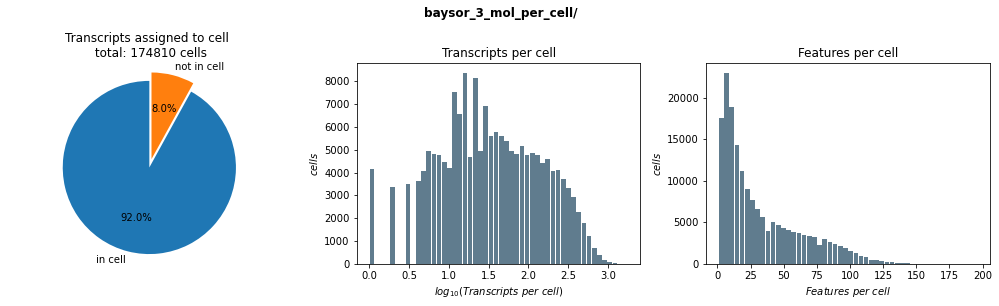

In [11]:
diagnostic_plots(transcripts, path)

Now we can put all together and create a image.

In order to plot the polygon, we need to transform the position to the image pixed for the polygons too. The polygons only have x and y (2d). But we can easlily create the 2d wrapper function around `rescale_fun`. This then can be applied to the Geopandas polygon (see the example below)

In [ ]:
def rescale_fun_2d(x,y):
    ones = np.ones(len(x))
    res = rescale_fun(x,y,ones)
    return(res[0],res[1])
    

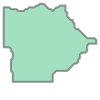

In [ ]:
transform(rescale_fun_2d, boundaries.geometry[0])

Now we can put all together and create a image.

In [ ]:
fig = plt.figure(figsize = (250,250))
ax = fig.add_subplot(111)
print(">>> plotting image")
ax.imshow(
    make_image(img),
    interpolation = "nearest",
    origin='lower'
)
print(">>> plotting transcripts")
ax.scatter(
    rescale_fun(transcripts.x, transcripts.y, transcripts.z)[0],
    rescale_fun(transcripts.x, transcripts.y, transcripts.z)[1],
    s=0.05, c=transcripts.ncv_color)
print(">>> plotting cell boundaries")
boundaries.geometry.apply(lambda x: transform(rescale_fun_2d, x)).boundary.plot(ax = ax, linewidth=0.5, edgecolor="red")
# ax.axis('off')
# fig.tight_layout()
print(">>> saving jpg")
fig.savefig(path+'/overlay.jpg', dpi = 100)

In [ ]:
fig = plt.figure(figsize = (250,250))
ax = fig.add_subplot(111)
print(">>> plotting image")
ax.imshow(
    make_image(img),
    interpolation = "nearest",
    origin='lower'
)
# print(">>> plotting transcripts")
# ax.scatter(transcripts.x*scales[0], transcripts.y*scales[1], s=0.01, c=transcripts.ncv_color)
print(">>> plotting cell boundaries")
boundaries.geometry.apply(lambda x: transform(rescale_fun_2d, x)).boundary.plot(ax = ax, linewidth=0.5, edgecolor="white")
ax.axis('off')
fig.tight_layout()
print(">>> saving jpg")
fig.savefig(path+'/overlay_no_transcripts.jpg', dpi = 100)